# Brooke Hunter Lab 3 Submission
Lab 3: Where is the nearest **Theatre**?

**Objectives:**
   * We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
   * Learn about OSM data stuctures
   * Compute walking distances using just a few lines of code
   * Visualize our data using `folium`

## Question 1 (20 points):
Write a script that:

* Computes the Euclidean distance to another **amenity** of your choosing (HINT: use `gdf['amenity'].unique()` to list the different amenities). Feel free to download OSM buildings from another place and choose a different home' location.


* Makes an interactive map showing where your ten nearest amenities are using `folium`. 

In [1]:
# Import modules
import osmnx as ox 

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

C:\Users\brdeh\anaconda3\envs\lab3\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\brdeh\anaconda3\envs\lab3\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [2]:
print(gdf.columns.tolist())

['addr:state', 'building', 'ele', 'gnis:county_id', 'gnis:created', 'gnis:feature_id', 'name', 'operator', 'geometry', 'access', 'wheelchair', 'source', 'ref', 'amenity', 'description', 'opening_hours', 'information', 'tourism', 'addr:city', 'addr:housenumber', 'addr:street', 'brand', 'brand:wikidata', 'brand:wikipedia', 'cuisine', 'takeaway', 'addr:postcode', 'bus', 'network', 'public_transport', 'fee', 'leisure', 'sport', 'material', 'emergency', 'nodes', 'building:levels', 'gnis:county_name', 'internet_access', 'shop', 'url', 'wikidata', 'wikipedia', 'name:ja', 'phone', 'website', 'air_conditioning', 'delivery', 'diet:vegan', 'denomination', 'religion', 'internet_access:fee', 'smoking', 'government', 'office', 'email', 'layer', 'location', 'man_made', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'drive_through', 'short_name', 'boundary', 'heritage', 'heritage:operator', 'nrhp:criteria', 'nrhp:inscription_date', 'nrhp:nhl', 'protection_title', 'ref:nrhp', 'name_1', 

In [3]:
# Count number of non-NaNs in each column
gdf.count()

addr:state           565
building           55533
ele                   24
gnis:county_id        16
gnis:created          17
                   ...  
yelp                   1
surface                1
ways                  77
type                  77
contact:website        1
Length: 231, dtype: int64

In [4]:
gdf['amenity'].unique()

array([nan, 'restaurant', 'fuel', 'fire_station', 'cafe',
       'place_of_worship', 'fast_food', 'library', 'theatre', 'shelter',
       'school', 'bank', 'studio', 'dentist', 'social_facility',
       'training', 'pub', 'college', 'cinema', 'conference_centre',
       'community_centre', 'police', 'parking', 'doctors', 'post_office',
       'clinic', 'bus_station', 'prison', 'courthouse', 'veterinary',
       'music_school', 'bar', 'nightclub', 'car_wash', 'animal_shelter',
       'toilets', 'biergarten', 'childcare', 'recycling', 'marketplace',
       'bicycle_parking', 'arts_centre', 'events_venue', 'social_centre',
       'ice_cream'], dtype=object)

### Filter Theatres below

In [5]:
# Filter theatres
theatres = gdf[gdf['amenity'] == 'theatre'].reset_index()
theatres

,element_type,osmid,addr:state,building,ele,gnis:county_id,gnis:created,gnis:feature_id,name,operator,...,house:soliciting,soliciting,covered,facebook,opening_hours:url,yelp,surface,ways,type,contact:website
0,way,203427041,OR,roof,NaN,NaN,NaN,NaN,Cuthbert Amphitheater,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,311045614,NaN,yes,NaN,NaN,NaN,NaN,Upstart Crow Studios,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,315741025,NaN,yes,NaN,NaN,NaN,NaN,Very Little Theater,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,412267069,NaN,yes,NaN,NaN,NaN,NaN,Hult Center for the Performing Arts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,420119848,NaN,yes,NaN,NaN,NaN,NaN,Oregon Contemporary Theatre,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Reprogect to UTM and get centroids of Theatres and Cascade Hall

In [6]:
# Reproject to UTM Zone 10N
gdf = gdf.to_crs('EPSG:32610')
theatres = theatres.to_crs('EPSG:32610')
# Get coordinates of Cascade Hall
cascade_hall = gdf[gdf['name'] == 'Cascade Hall'].reset_index()

# Get Theatre and Cascade Hall centroids
theatres['centroid'] = theatres['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

cascade_hall['centroid'] = cascade_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

### Compute Distances

In [7]:
# Compute distances
cascade_hall_x = cascade_hall['centroid'].x.values[0]
cascade_hall_y = cascade_hall['centroid'].y.values[0]
distances = np.sqrt(((cascade_hall_x - theatres['centroid'].x.values)**2)
                     + ((cascade_hall_y - theatres['centroid'].y.values)**2))

# Add to GeoDataFrame
theatres['euclidean_distance'] = distances
print(theatres.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                                  name  euclidean_distance
0                Cuthbert Amphitheater         1106.016895
2                  Very Little Theater         1534.108047
3  Hult Center for the Performing Arts         1717.247614
4          Oregon Contemporary Theatre         1777.116148
1                 Upstart Crow Studios         2919.983829


### Import Folium and Plot

In [8]:
# Make a new DataFrame containing only the three most relevant columns
nearest_theatres = theatres.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_theatres = nearest_theatres.set_geometry('centroid')

# Convert back to WGS84
nearest_theatres = nearest_theatres.to_crs('EPSG:4326')


# Import package
import folium

# Define center of map (i.e. Cascade Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_theatres.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_theatres.iloc[i]['name'], nearest_theatres.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_theatres.iloc[i]['centroid'].y, nearest_theatres.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

## Question 2 (20 points): 

Adapt the code above to compute the network distance between two points (either in Eugene or in a city of your choice) and show your results using an interactive map. Write a few sentences about what your map shows.

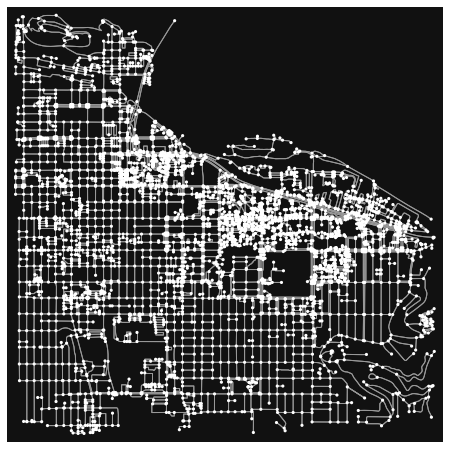

In [9]:
# Import module
import networkx as nx
# Define coordinates of Cascade Hall
lat_lon = (44.0451, -123.0781)

# Import walkable street network data around Cascade Hall
g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [10]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

# Convert the theatre dataset back to UTM Zone 10N
nearest_theatres = nearest_theatres.to_crs('EPSG:32610')

Coordinate system: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [14]:
# Get x and y coordinates of Cascade Hall
orig_xy = (cascade_hall['centroid'].y.values[0], cascade_hall['centroid'].x.values[0])

# Get x and y coordinates of one of the theatres (the furthest of the ten)
target_xy = (nearest_theatres['centroid'].y.values[-1], nearest_theatres['centroid'].x.values[-1])

In [15]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [16]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [17]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

## Write a few sentances about what your map shows
This map shows the shortest path to get from Cascade Hall to the Hult Center (which is the closest theatre in the inventory). 

## Question 3 (10 points): 


* a) Calculate the average difference between the Euclidean and network distances for you amenities 


* b) Describe some situations where it would not be advisable to use Euclidean distances?

In [ ]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Print length of route
print('Walking distance to %s = %.1f km' % (nearest_theatres['name'].iloc[-1], route_geom['geometry'].length / 1000))

In [ ]:
# Get x and y coordinates of all ten of the nearest theatres
target_xy = (nearest_theatres['centroid'].y.values, nearest_theatres['centroid'].x.values)

In [ ]:
routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_theatres['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

In [ ]:
nearest_theatres['network_distance'] = distances
nearest_theatres

In [ ]:
Derscribe some sits where it would not be advisable to udce euclidean

## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**